In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import pandas as pd
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./Training/datalog.csv')
df.head()

,Image,Class
0,./Training/vehicles/GTI_Left/image0875.png,1
1,./Training/vehicles/GTI_Left/image0619.png,1
2,./Training/vehicles/GTI_Left/image0174.png,1
3,./Training/vehicles/GTI_Left/image0922.png,1
4,./Training/vehicles/GTI_Left/image0306.png,1


In [38]:
x_data = []
y_data = []
for imagefile,y in zip(df['Image'],df['Class']):
    img = cv2.imread(imagefile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_data.append(img)
    y_data.append(y)
    x_data.append(np.flip(img,1))
    y_data.append(y)
    x_data.append(np.flip(img,0))
    y_data.append(y)
    for i in range(5):
        n = np.random.randint(32,64) 
        resultimg = np.zeros_like(img)
        rimg = cv2.resize(img,(n,n))
        resultimg[:n,:n,:]=rimg
        x_data.append(resultimg)
        y_data.append(y)
    
x_data = np.array(x_data)
y_data = np.array(y_data)

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_data,y_data)

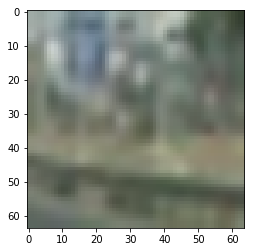

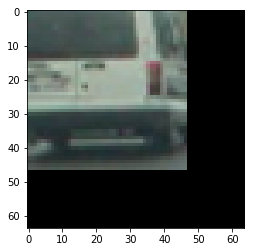

In [40]:
plt.imshow(X_train[6])
plt.show()
plt.imshow(X_train[1])
plt.show()

In [41]:
from keras.applications.xception import Xception
from keras.layers import Lambda

imageshape = (64,64,3)
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(imageshape)))
model.add(Xception(weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
xception (Model)             multiple                  20861480  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 22,960,681
Trainable params: 22,906,153
Non-trainable params: 54,528
_________________________________________________________________


In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc'])
model.fit(X_train,y_train, validation_split=0.2, batch_size=128, epochs=2)

Train on 85248 samples, validate on 21312 samples
Epoch 1/2
85248/85248 [==============================] - 246s 3ms/step - loss: 0.0324 - acc: 0.9926 - val_loss: 0.0054 - val_acc: 0.9981
Epoch 2/2
85248/85248 [==============================] - 243s 3ms/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.0092 - val_acc: 0.9977


In [43]:
from keras.models import load_model
model.save('my_model.h5')

In [44]:
from keras.models import load_model
model = load_model('my_model.h5')

In [45]:
scores = model.evaluate(X_test, y_test, verbose=0, batch_size = 256)

In [46]:
print (scores)

[0.011400078001545128, 0.99735360360360359]


In [10]:
from numba import jit
from numpy import arange

@jit
def slidingwindow(image,winsize,wingrowfactor,starty,xstride,ystride):
    boxes = []
    ymax, xmax = image.shape[0],image.shape[1]
    result = []
    w = winsize 
    for y in range(starty,ymax-w,ystride):
        xs = xstride + int(wingrowfactor*(y-starty))
        for x in range(0,xmax-w,xs):
            img = image[y:y+w,x:x+w,:]
            img = cv2.resize(img,(64,64))
            result.append(img)
            boxes.append(((x,y),(x+w,y+w)))
        w =  int(winsize+ wingrowfactor*(y-starty))
        
    return np.array(result),boxes

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

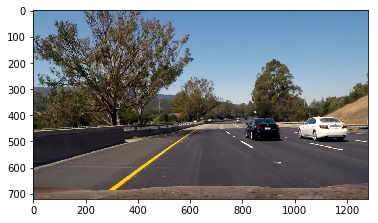

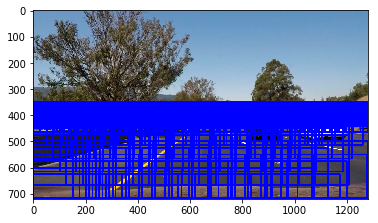

In [20]:
imagefile = './test_images/test6.jpg'
img = cv2.imread(imagefile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
frame,boxes = slidingwindow(img,90,1,350,2,25)
result = draw_boxes(img,boxes)
plt.imshow(result)
plt.show()

In [21]:
result = model.predict(frame)

In [22]:
def draw_boxes2(img, bboxes, result,minprob, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    font = cv2.FONT_HERSHEY_SIMPLEX
    for bbox,r in zip(bboxes,result):
        # Draw a rectangle given bbox coordinates
        if (r>minprob):
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
            cv2.putText(imcopy, 'Prob: {0:.3f}'.format(r[0]),(bbox[0][0]-10,bbox[0][1]),font,1,(255,255,255),2,cv2.LINE_AA)
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
def add_heat(heatmap, bbox_list,result):
    # Iterate through list of bboxes
    for box,r in zip(bbox_list,result):
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += r
    # Return updated heatmap
    return heatmap

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [25]:
def draw_labeled_bboxes(img, labels):
    copyimg = np.copy(img)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(copyimg, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return copyimg

In [26]:
def labeled_bboxes(img, labels):
    bboxes = []
    frames = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
        frame = img[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0],:]
        if (frame.shape[0]>0 and frame.shape[1]>0):
            frames.append(cv2.resize(frame,(64,64)))
    # Return the image
    frames = np.array(frames)
    frames = frames.reshape(-1,64,64,3)
    return bboxes,frames

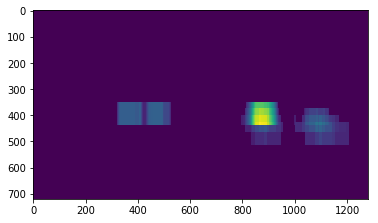

3 cars found


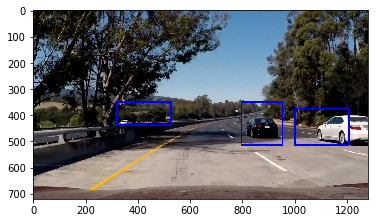

In [53]:
from scipy.ndimage.measurements import label
heatmap = np.zeros((img.shape[0],img.shape[1]))
heatmap = add_heat(heatmap,boxes,result)
heatmap = apply_threshold(heatmap, 2)
plt.imshow(heatmap)
plt.show()

labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(draw_labeled_bboxes(img,labels))

In [36]:
def process_image(img):
    frame,boxes = slidingwindow(img,90,1,350,2,25)
    result = model.predict(frame)
    copyimage = np.copy(img)
    heatmap = np.zeros((img.shape[0],img.shape[1]))
    heatmap = add_heat(heatmap,boxes,result)
    heatmap = apply_threshold(heatmap,2)
    labels = label(heatmap)
    bboxes, frames = labeled_bboxes(img,labels)
    result = model.predict(frames)
    result = draw_boxes2(img, bboxes,result, .95)
    return result

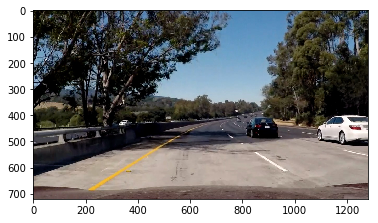

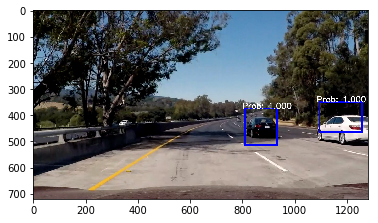

In [48]:
imagefile = './test_images/test5.jpg'
img = cv2.imread(imagefile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
plt.imshow(process_image(img))
plt.show()

In [50]:
test_output = 'test_videoresultdl.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip('test_video.mp4')
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videoresultdl.mp4
[MoviePy] Writing video test_videoresultdl.mp4


 97%|█████████▋| 38/39 [00:27<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videoresultdl.mp4 

CPU times: user 26.8 s, sys: 3.13 s, total: 29.9 s
Wall time: 28.2 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [466]:
challenge_output = 'project_videoresultdl.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('project_video.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_videoresultdl.mp4
[MoviePy] Writing video project_videoresultdl.mp4



100%|█████████▉| 1260/1261 [15:55<00:00,  1.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_videoresultdl.mp4 

CPU times: user 15min 23s, sys: 1min 55s, total: 17min 18s
Wall time: 15min 55s


In [467]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
video_output = './solidWhiteRightresult.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('solidWhiteRight.mp4')
video_clip = clip3.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)